In [1]:
import matplotlib.pyplot as plt
from src.models import *
from src.model_analysis.utils import same_output
from src.post_quant.cle import cle_for_resmlp, cle_for_resmlp_v3
# from src.post_quant.bias_absorb import ba_for_resmlp
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels, get_linear_layers

org_model = resmlp_24_v3(pretrained=True).eval()
model1 = resmlp_24(pretrained=True).eval()
model2 = resmlp_24_v3(pretrained=True).eval()
# print(same_output(model1, org_model, eps=1e-5))

# model_norm = resmlp_24_norm(pretrained=False).eval()
# model_norm.load_state_dict(torch.load("771.pth")["model"])
# qmodel = q_resmlp_v3(model)

# # test CLE
# org_model = resmlp_24(pretrained=False).eval()
# org_model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# model = resmlp_24(pretrained=False).eval()
# model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# cle_for_resmlp(model)


c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
a = (name for name, p in model1.named_parameters() if 'bias' in name)

for name in a:
    print(name)

patch_embed.proj.bias
blocks.0.norm1.bias
blocks.0.attn.bias
blocks.0.norm2.bias
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.bias
blocks.1.norm1.bias
blocks.1.attn.bias
blocks.1.norm2.bias
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.bias
blocks.2.norm1.bias
blocks.2.attn.bias
blocks.2.norm2.bias
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.bias
blocks.3.norm1.bias
blocks.3.attn.bias
blocks.3.norm2.bias
blocks.3.mlp.fc1.bias
blocks.3.mlp.fc2.bias
blocks.4.norm1.bias
blocks.4.attn.bias
blocks.4.norm2.bias
blocks.4.mlp.fc1.bias
blocks.4.mlp.fc2.bias
blocks.5.norm1.bias
blocks.5.attn.bias
blocks.5.norm2.bias
blocks.5.mlp.fc1.bias
blocks.5.mlp.fc2.bias
blocks.6.norm1.bias
blocks.6.attn.bias
blocks.6.norm2.bias
blocks.6.mlp.fc1.bias
blocks.6.mlp.fc2.bias
blocks.7.norm1.bias
blocks.7.attn.bias
blocks.7.norm2.bias
blocks.7.mlp.fc1.bias
blocks.7.mlp.fc2.bias
blocks.8.norm1.bias
blocks.8.attn.bias
blocks.8.norm2.bias
blocks.8.mlp.fc1.bias
blocks.8.mlp.fc2.bias
blocks.9.norm1.bias
blocks.9.attn.bias
blocks.9.nor

In [16]:
from torchsummary import summary
summary(model1, input_size=(3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
            Linear-4             [-1, 196, 384]         147,840
            Linear-5             [-1, 384, 196]          38,612
            Linear-6             [-1, 196, 384]         147,456
          Identity-7             [-1, 196, 384]               0
          Identity-8             [-1, 196, 384]               0
            Linear-9             [-1, 196, 384]         147,840
           Linear-10            [-1, 196, 1536]         591,360
             ReLU-11            [-1, 196, 1536]               0
          Dropout-12            [-1, 196, 1536]               0
           Linear-13             [-1, 196, 384]         590,208
          Dropout-14             [-1, 1

([<matplotlib.axis.XTick at 0x1b651ea1d00>,
 [Text(1, 0, '0-inner'), Text(2, 0, '0-mlp.fc1'), Text(3, 0, '0-mlp.fc2')])

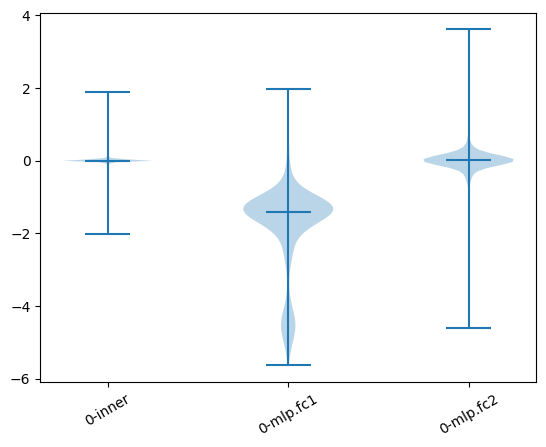

In [5]:
model_layers = []
for i in range(0, 1):
    todo_layer = model2.blocks[i]
    model_layers.append(get_linear_layers(todo_layer, specify_names=None, prefix=f"{i}-"))
# print(model_layers[0].weight.detach().numpy().flatten())

data = []
labels = []
for layer in model_layers:
    for n, m in layer:
        val = m.bias
        if val is not None:
            data.append(val[val.nonzero(as_tuple=True)].detach().numpy().flatten())
            labels.append(n)

plt.violinplot(data, showmedians=True, showextrema=True)
plt.xticks(range(1, len(labels) + 1), labels, rotation=30)

{'whiskers': [<matplotlib.lines.Line2D at 0x13b0522ffa0>,
 'caps': [<matplotlib.lines.Line2D at 0x13b05240520>,
 'boxes': [<matplotlib.lines.Line2D at 0x13b0522fd00>,
 'medians': [<matplotlib.lines.Line2D at 0x13b05240a60>,
 'fliers': [<matplotlib.lines.Line2D at 0x13b05240d00>,
 'means': []}

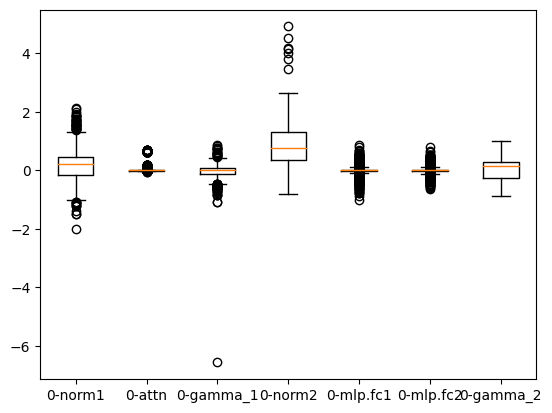

In [21]:
model_layers = []
for i in range(0, 1):
    todo_layer = model1.blocks[i]
    model_layers.append(get_linear_layers(todo_layer, specify_names=None, prefix=f"{i}-"))
# print(model_layers[0].weight.detach().numpy().flatten())

data = []
labels = []
for layer in model_layers:
    for n, m in layer:
        val = m.weight
        data.append(val[val.nonzero(as_tuple=True)].detach().numpy().flatten())
        labels.append(n)

plt.boxplot(data, labels=labels, showfliers=False)

In [21]:
l1 = model1.blocks[5].norm1.eval()
l2 = model1.blocks[5].attn.eval()
l3 = model1.blocks[5].gamma_1.eval()

print(l1.weight.shape, l2.weight.shape, l3.weight.shape)

x = torch.randn(1, 196, 384)

# F.linear(l1.weight, l2.weight)
# l1(x)

# fuse the three linears

W1 = l1.weight * l3.weight
B1 = l1.bias.repeat(196,1)@ l3.weight + torch.inverse(l2.weight) @ l2.bias.repeat(384,1).T @ l3.weight

W2 = l2.weight
# weight = l2.weight @ l1.weight
# bias = l2.bias + F.linear(l2.weight, l1.bias)

out1 = l3(l2(l1(x).transpose(1,2)).transpose(1,2))
out2 = W2 @ (x @ W1 + B1)
torch.allclose(out1, out2, atol=1e-4)

torch.Size([384, 384]) torch.Size([196, 196]) torch.Size([384, 384])


True

In [23]:
r1 = W1.abs().max()
r2 = W2.abs().max()
sT = torch.sqrt(r1*r2)/r2

W2_new = W2 * sT
W1_new = W1 / sT
B1_new = B1 / sT

print(sT)

out3 = W2_new @ (x @ W1_new + B1_new)
torch.allclose(out3, out2, atol=1e-5)

tensor(1.9382, grad_fn=<DivBackward0>)


True

In [16]:
print(W1_new.abs().max(), W2_new.abs().max())

tensor(0.8474, grad_fn=<MaxBackward1>) tensor(0.8474, grad_fn=<MaxBackward1>)


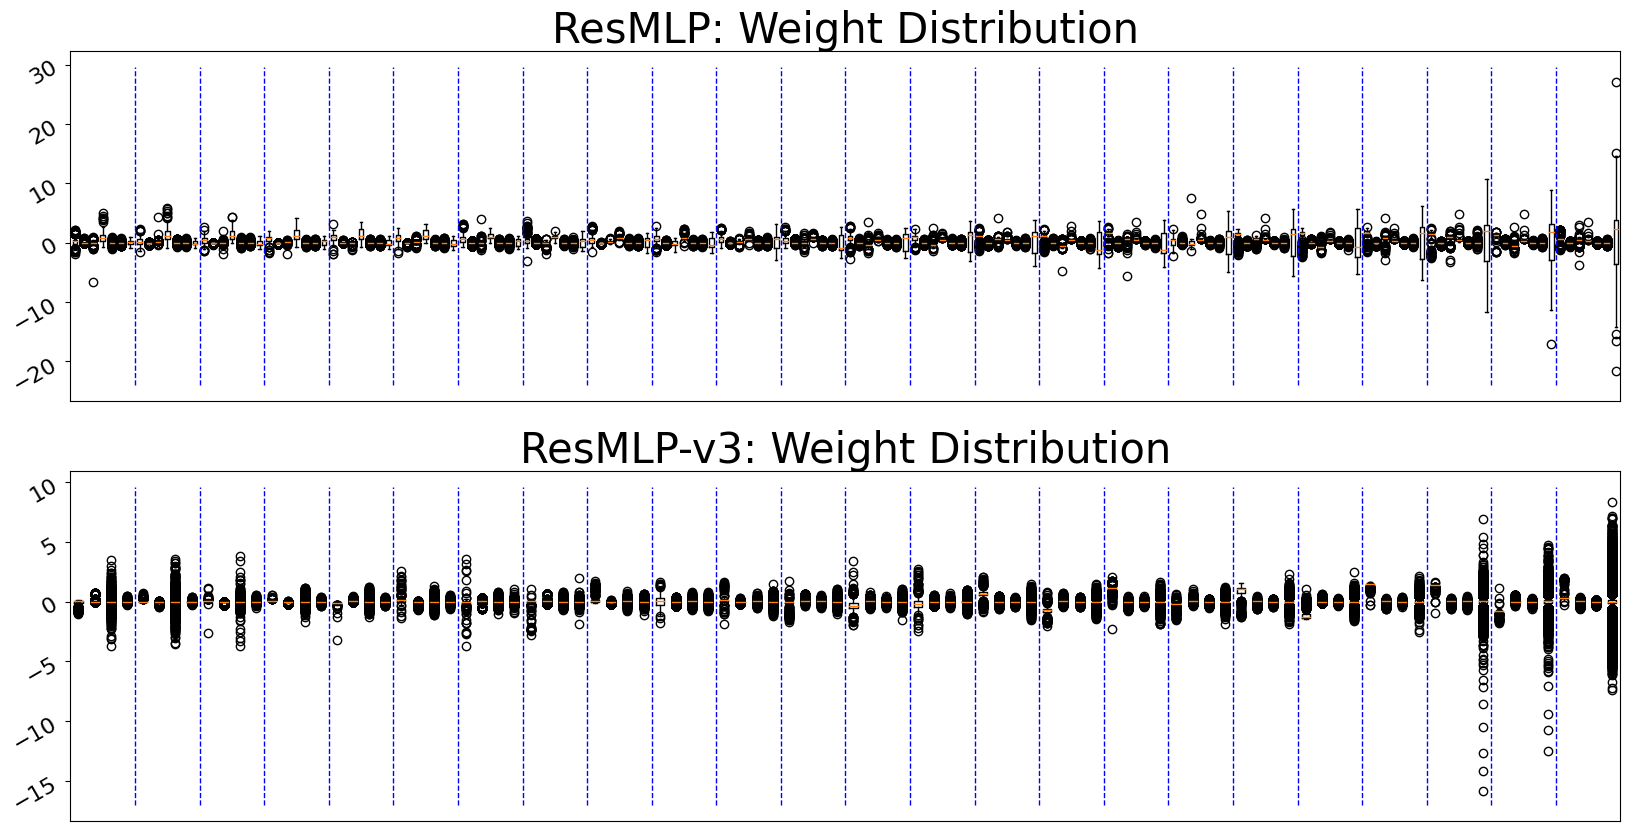

In [7]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
# model2.cpu()
layer_dist(model1, 0, 23, name="ResMLP: Weight Distribution", ax=ax[0], type="weight")

# model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(model2, 0, 23, name="ResMLP-v3: Weight Distribution", ax=ax[1], type="weight")

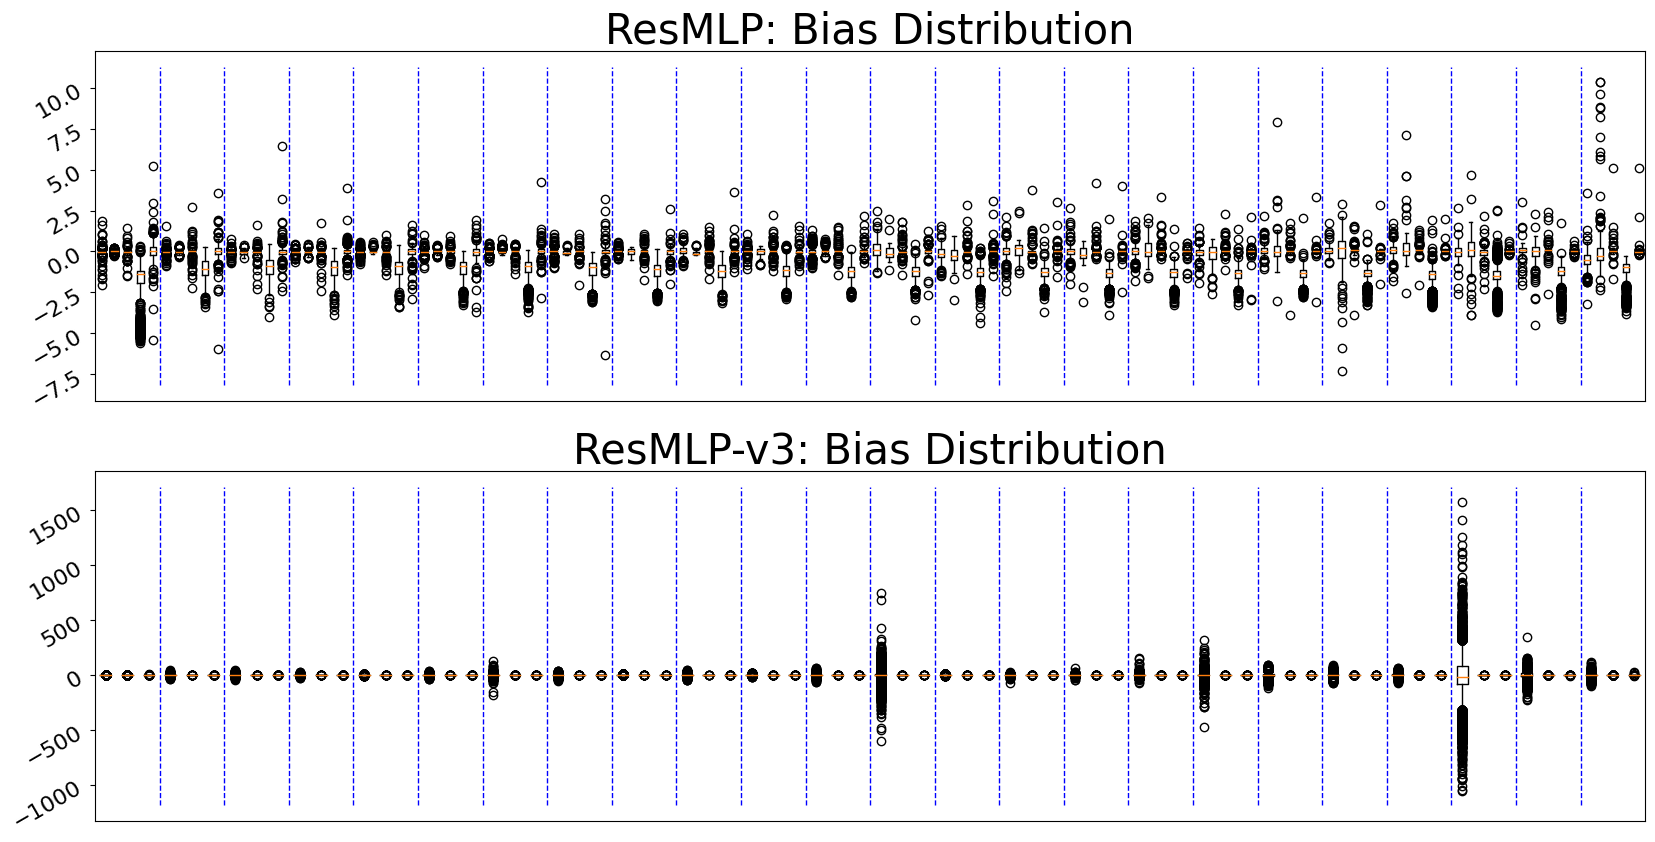

In [24]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
# model2.cpu()
layer_dist(model1, 0, 23, name="ResMLP: Bias Distribution", ax=ax[0], type="bias")

# model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(model2, 0, 23, name="ResMLP-v3: Bias Distribution", ax=ax[1], type="bias")

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  8.247 ( 8.247)
Calibrate: [10/21]	Time  0.678 ( 1.365)
Calibrate: [20/21]	Time  0.074 ( 1.000)


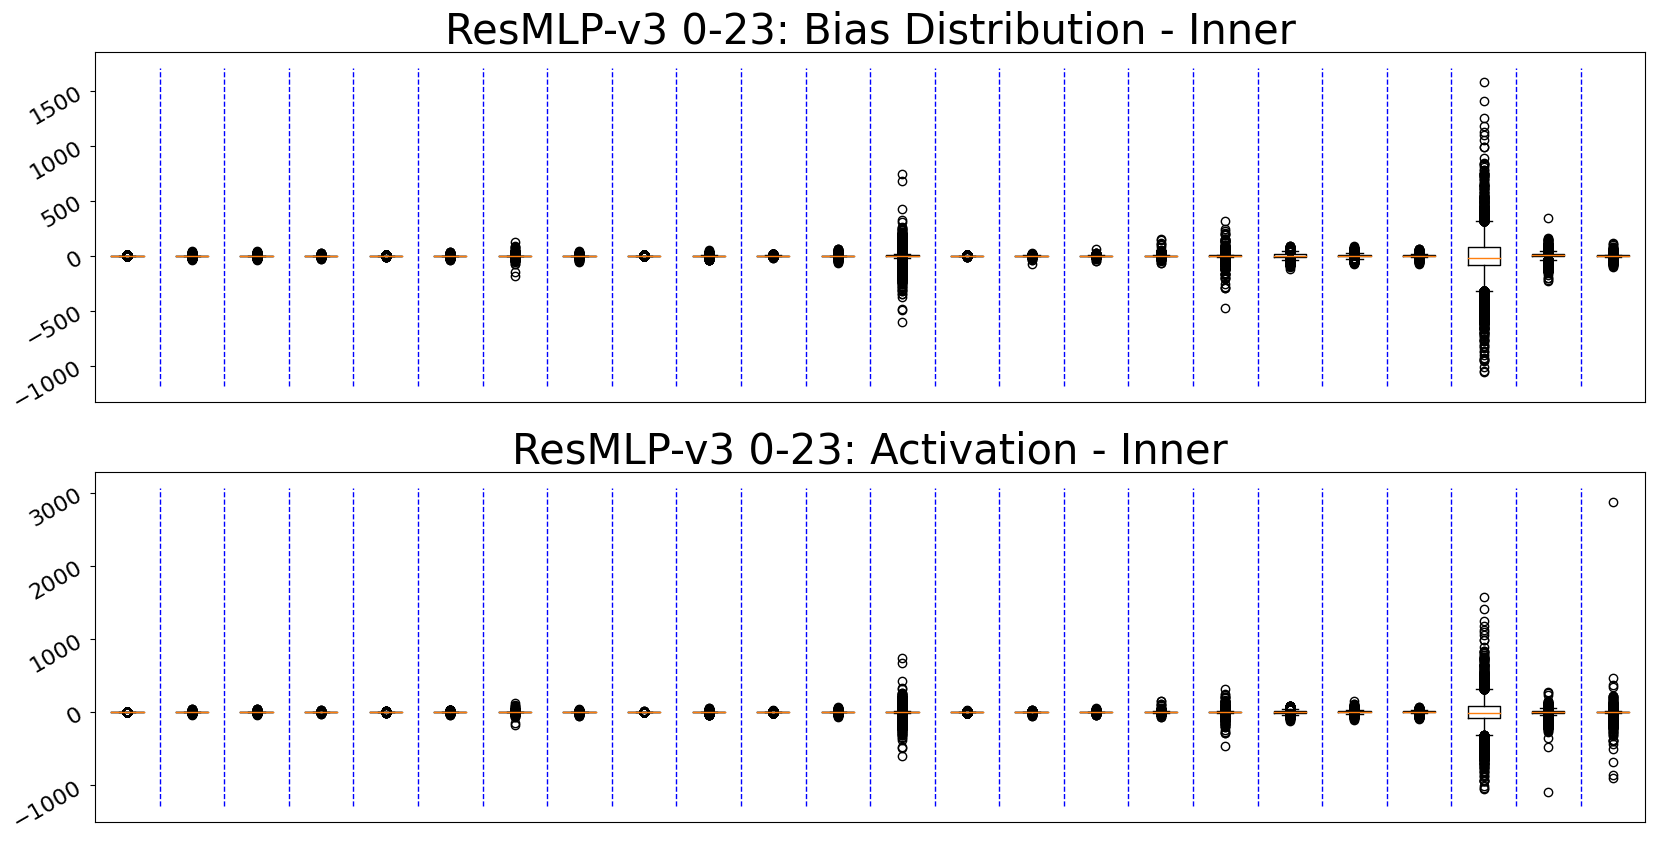

In [11]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model2.cpu()
layer_dist(model2, 0, 23, name="ResMLP-v3 0-23: Bias Distribution - Inner", show_layers=["inner"], ax=ax[0], type="bias")

model2.cuda()
# cle_for_resmlp_v3(model2)
# layer_dist(model2, 0, 10, name="ResMLP-v3: Bias Distribution - Others", show_layers=["outer", "mlp.fc1", "mlp.fc2"], ax=ax[1], type="bias")
act_dist(model2, 0, 23, name='ResMLP-v3 0-23: Activation - Inner', show_layers=["inner"], ax=ax[1], real_sim=True)

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.336 ( 9.336)
Calibrate: [10/21]	Time  1.742 ( 2.388)
Calibrate: [20/21]	Time  0.193 ( 1.986)
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.337 ( 9.337)
Calibrate: [10/21]	Time  2.128 ( 2.765)
Calibrate: [20/21]	Time  0.274 ( 2.363)


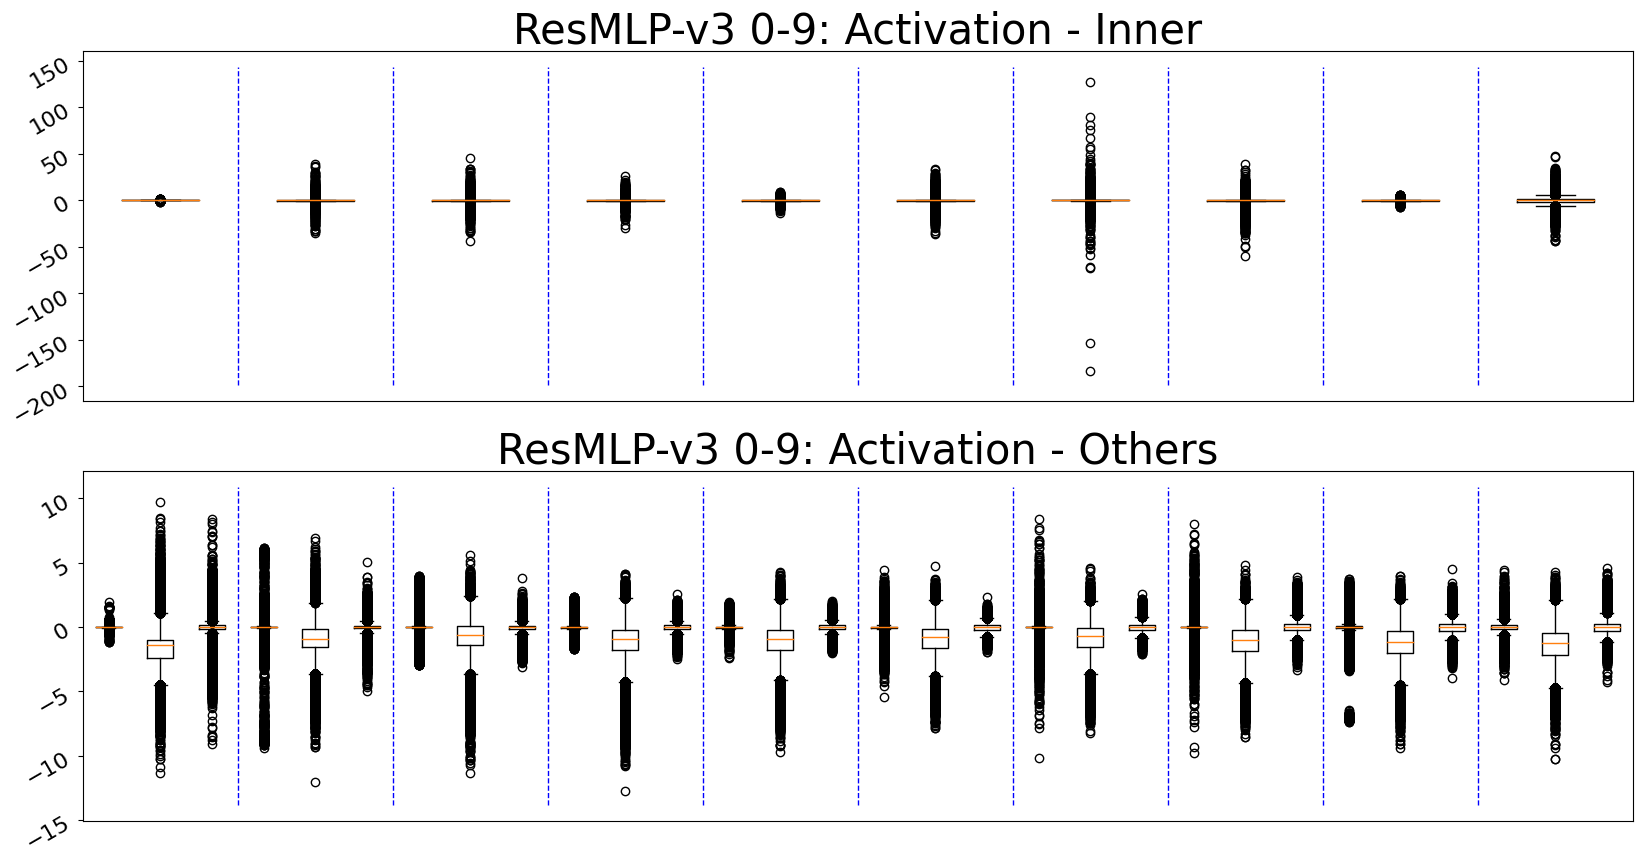

In [14]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model2.cuda()
act_dist(model2, 0, 9, name='ResMLP-v3 0-9: Activation - Inner', show_layers=["inner"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
model2.cuda()
act_dist(model2, 0, 9, name='ResMLP-v3 0-9: Activation - Others', show_layers=["outer", "mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model1.cuda()
act_dist(model1, 0, 23, name='ResMLP: Activation Distribution', show_layers=["inner", "mlp.fc2"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
model2.cuda()
act_dist(model2, 0, 23, name='ResMLP-v3: Activation Distribution', show_layers=["mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)